Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib import cm
import datetime as dt
import os
import openpyxl
from osgeo import gdal
import netCDF4
from dateutil.relativedelta import relativedelta
import re
import pandas as pd
import xarray as xr
import geopandas as gpd
import glob
import simple_colors
import cartopy.crs as ccrs
from datetime import datetime
from colorama import Fore #for colored terminal text and cursor positioning
from osgeo import ogr, gdal, osr #for raster operations

## Processing Spatial SWAT+ outputs

#### Import SWAT+ txt output file

The SWAT+ output used in this notebook is the monthly hru water balance file (hru_wb_mon.txt)

The first row is skipped since it contains the summary of model version. The next row is similary skipped since it contains the column units


In [2]:
# define path to hru water balance file and hru corresponding hru shapefile
hru_txt_path= r'H:\raw_cordex_rcmdata\for_swatplus\swat+_models\racmo22t\nyando_cca_hist\Scenarios\Default\TxtInOut'
hru_shp_path=r'H:\raw_cordex_rcmdata\for_swatplus\swat+_models\racmo22t\nyando_cca_hist\Watershed\Shapes'

#hru water balance file columns
col_names = ['jday', 'mon', 'day', 'yr', 'unit', 'gis_id', 'name', 'precip', 'snofall', 'snomlt', 'surq_gen', 'latq', 'wateryld', 'perc', 'et', 'ecanopy', 'eplant', 'esoil', 'surq_cont', 'cn', 'sw_init', 'sw_final', 'sw_ave', 'sw_300', 'sno_init', 'sno_final', 'snopack', 'pet', 'qtile', 'irr', 'surq_runon', 'latq_runon', 'overbank', 'surq_cha', 'surq_res', 'surq_ls', 'latq_cha', 'latq_res', 'latq_ls', 'gwtranq', 'satex', 'satex_chan', 'sw_change', 'lagsurf', 'laglatq', 'lagsatex']
             
hru_wb_mon= pd.read_csv(hru_txt_path +'\hru_wb_mon.txt',  delim_whitespace=True,skiprows=3,names=col_names) 
#  delimiter = r'\s+' also same as delim_whitespace #s+ is a regular expression for one or more spaces.
dataset=hru_wb_mon

### Import HRU Shapefile

In [3]:
hrus= gpd.read_file(hru_shp_path+'\hrus1.shp')
#fig, ax = plt.subplots(figsize=(6,6))
#hrus.plot(ax=ax, **{'edgecolor':'k', 'facecolor':'white'})
hrus.crs #get projection info

<Projected CRS: EPSG:32637>
Name: WGS 84 / UTM zone 37N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 36°E and 42°E, northern hemisphere between equator and 84°N, onshore and offshore. Djibouti. Egypt. Eritrea. Ethiopia. Georgia. Iraq. Jordan. Kenya. Lebanon. Russian Federation. Saudi Arabia. Somalia. Sudan. Syria. Turkey. Ukraine.
- bounds: (36.0, 0.0, 42.0, 84.0)
Coordinate Operation:
- name: UTM zone 37N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
hru_names=hrus[['HRUS','geometry']]
hrus['hrus']=('hru'+hrus.loc[:,'HRUS']) #Create a column with 'hru' appended to hru numbers
hrus

,Subbasin,Channel,Landscape,Landuse,Soil,SlopeBand,Area,%Subbasin,%Landscape,HRUS,LINKNO,geometry,hrus
0,1,66,NA,COFF,Nh2-2c-848,0-8,271.35,17.8,41.5,1,8,"MULTIPOLYGON (((77060.638 12062.715, 77060.638...",hru1
1,1,66,NA,COFF,Nh2-2c-848,8-16,305.37,20.0,46.7,2,8,"MULTIPOLYGON (((77690.638 11882.715, 77420.638...",hru2
2,1,66,NA,COFF,Nh2-2c-848,16-32,72.09,4.7,11.0,3,8,"MULTIPOLYGON (((77150.638 11702.715, 77060.638...",hru3
3,1,66,NA,COFF,Nh2-2c-848,32-9999,5.67,0.4,0.9,4,8,"MULTIPOLYGON (((78590.638 9362.715, 78590.638 ...",hru4
4,1,65,NA,COFF,Nh2-2c-848,8-16,47.79,3.1,9.5,5,16,"MULTIPOLYGON (((75080.638 11612.715, 75080.638...",hru5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,204,1070,NA,CORN,Nh2-2c-848,32-9999,4.86,0.3,2.2,7347,111,"POLYGON ((55100.638 -42747.285, 55100.638 -425...",hru7347
7347,204,1070,NA,BSVG,Nh2-2c-848,16-32,5.67,0.4,2.6,7348,111,"MULTIPOLYGON (((55460.638 -42747.285, 55370.63...",hru7348
7348,204,1070,NA,BSVG,Nh2-2c-848,8-16,21.06,1.3,9.7,7349,111,"MULTIPOLYGON (((56090.638 -42837.285, 56000.63...",hru7349
7349,204,1070,NA,BSVG,Nh2-2c-848,0-8,5.67,0.4,2.6,7350,111,"MULTIPOLYGON (((56090.638 -42747.285, 56090.63...",hru7350


### Convert data types
Some numeric datatypes are read as as str types.
Convert the column values from the previous step to floats and append the float data as new columns in the dataframe.
Values with scientific notations are also read as string type, convert colums of interest to float and add the new cols
If no data in scientific format, this step can be skipped

Convert the datetime columns to integers and combine the dataframes

In [5]:
data_float=dataset.loc[:,['precip','et', 'pet','wateryld']].astype(float) #data columns to be converted to floats
data_int=dataset.loc[:,['mon','day','yr']]#.astype(int) #data columns to be converted to integers

data_extract=data_int.merge(data_float, left_index=True, right_index=True)
data_extract['HRUS']=dataset['name'] 
#pd.reset_option('display.float_format') #reset to default number of float decimals
#type(data_float['precip'])
#rename the HRU names to match those in the HRU shapefile
data_extract

,mon,day,yr,precip,et,pet,wateryld,HRUS
0,1,31,1982,39.74,121.085,149.349,0.183,hru0001
1,1,31,1982,39.74,120.155,149.352,1.647,hru0002
2,1,31,1982,39.74,119.365,149.355,2.023,hru0003
3,1,31,1982,39.74,118.108,149.384,1.471,hru0004
4,1,31,1982,39.74,120.190,149.357,1.611,hru0005
...,...,...,...,...,...,...,...,...
2117083,12,31,2005,30.38,30.380,146.404,0.000,hru7347
2117084,12,31,2005,30.38,38.334,146.207,0.000,hru7348
2117085,12,31,2005,30.38,40.895,146.194,0.000,hru7349
2117086,12,31,2005,30.38,46.595,146.164,0.000,hru7350


### Rename the HRUs 
Rename HRU names in the dataframe to match the hru names in the shapefile
select the last 4 digits of the name and convert to integer. e.g. In the txt file, the hru#1 is named as hru0001 while in the shapefile it is named hru1. This step removes the zeros preceding the number

In [6]:
data_extract['hrus_int'] =(data_extract.loc[:,'HRUS'].str[-4:]).astype(int)
data_extract['hrus']='hru'+data_extract.loc[:,'hrus_int'].map(str)
data_extract=data_extract.drop('hrus_int', axis=1) #drop the hru_int col
data_extract

,mon,day,yr,precip,et,pet,wateryld,HRUS,hrus
0,1,31,1982,39.74,121.085,149.349,0.183,hru0001,hru1
1,1,31,1982,39.74,120.155,149.352,1.647,hru0002,hru2
2,1,31,1982,39.74,119.365,149.355,2.023,hru0003,hru3
3,1,31,1982,39.74,118.108,149.384,1.471,hru0004,hru4
4,1,31,1982,39.74,120.190,149.357,1.611,hru0005,hru5
...,...,...,...,...,...,...,...,...,...
2117083,12,31,2005,30.38,30.380,146.404,0.000,hru7347,hru7347
2117084,12,31,2005,30.38,38.334,146.207,0.000,hru7348,hru7348
2117085,12,31,2005,30.38,40.895,146.194,0.000,hru7349,hru7349
2117086,12,31,2005,30.38,46.595,146.164,0.000,hru7350,hru7350


### Extract and summarize selected hru water balance components

Create monthly and annual summaries of hru water components using a pivot table function

Note: Select the variable to print at this stage. The variables are accessible in a dictionary and the options are et,precipitation(precip), water yield (wateryld) and potential ET (pet)

In [76]:
def summary_stats(dataframe):
        #create a date column by concatenating date elements and set the new date column as data index
        dataframe['full_date']=dataframe['day'].map(str)+'-'+dataframe['mon'].map(str)+'-'+dataframe['yr'].map(str)
        dataframe['date']=pd.to_datetime(dataframe['full_date'][1:])
        dataframe.set_index('date')
        dataframe['month'] = pd.DatetimeIndex(dataframe['date']).month #extract month from output
        dataframe['year'] = pd.DatetimeIndex(dataframe['date']).year #extract year from output
    
        #create a pivot with time summary of variable of interest e.g et.
        #Declaring global variables makes them accessible outside of the function
        global dataframe_monthly
        global dataframe_annual
        global variable_names
        global df_annual
        variable_names=['et','precip', 'wateryld','pet']     
        
        #create monthly means and annual total water balance output using pivot table
        df_monthly=[]
        df_annual=[]
        for var in variable_names:

            dataframe_monthly=data_extract.pivot_table(index='hrus', values=var, columns='month', aggfunc='mean')
            dataframe_monthly.columns=str(var)+'_'+(dataframe_monthly.columns.map(int)).map(str)
            df_monthly.append(dataframe_monthly)
            months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']
            dataframe_monthly.columns=months

            dataframe_annual=dataframe.pivot_table(index='hrus', values=var, columns='year', aggfunc='sum')
            dataframe_annual.columns=str(var)+'_'+(dataframe_annual.columns.map(int)).map(str)
            df_annual.append(dataframe_annual)
                        
        return dataframe_annual, df_annual
        

summary_stats(data_extract)

(year     pet_1982  pet_1983  pet_1984  pet_1985  pet_1986  pet_1987  pet_1988  \
 hrus                                                                            
 hru1     1279.028  1473.859  1414.973  1409.385  1375.771  1519.641  1412.931   
 hru10    1429.712  1475.004  1416.202  1410.627  1377.190  1520.654  1414.252   
 hru100   1431.179  1482.605  1416.148  1412.076  1380.438  1524.231  1427.637   
 hru1000  1417.290  1464.364  1404.790  1399.082  1363.966  1511.221  1401.965   
 hru1001  1418.574  1465.466  1405.971  1400.276  1365.336  1512.198  1403.238   
 ...           ...       ...       ...       ...       ...       ...       ...   
 hru995   1415.320  1462.677  1402.981  1397.251  1361.868  1509.724  1400.015   
 hru996   1415.589  1462.911  1403.227  1397.504  1362.156  1509.929  1400.284   
 hru997   1416.567  1463.748  1404.128  1398.411  1363.198  1510.673  1401.251   
 hru998   1418.165  1465.115  1405.594  1399.897  1364.900  1511.887  1402.830   
 hru999   1418.2

In [80]:
#create a dictionary of water balance outputs for easy access
var_dict={'et':df_annual[0],'precip':df_annual[1],'wateryld':df_annual[2],'pet':df_annual[3]}
#list(var_dict)[0]

In [82]:
var_dict['et']

year,et_1982,et_1983,et_1984,et_1985,et_1986,et_1987,et_1988,et_1989,et_1990,et_1991,...,et_1996,et_1997,et_1998,et_1999,et_2000,et_2001,et_2002,et_2003,et_2004,et_2005
hrus,,,,,,,,,,,,,,,,,,,,,
hru1,1072.695,1213.714,900.136,903.607,876.168,968.362,906.756,948.329,916.279,849.989,...,1166.805,966.880,875.665,993.276,944.251,866.292,921.610,929.405,912.541,861.917
hru10,1255.282,1284.455,1189.067,1195.420,1199.527,1190.043,1225.875,1354.947,1397.655,1166.519,...,1268.778,1177.685,1345.791,1366.777,1201.758,1311.453,1421.722,1235.268,1398.523,1324.991
hru100,1180.589,1224.807,425.967,427.605,416.971,467.200,448.781,488.312,468.399,446.618,...,1450.953,854.918,434.889,838.325,506.671,480.980,450.872,469.410,502.432,436.554
hru1000,1299.289,1435.373,1308.019,1227.424,1357.679,1390.570,1235.152,1477.201,1424.931,1270.558,...,1421.449,1309.326,1363.725,1454.022,1313.148,1340.705,1450.833,1421.114,1419.651,1347.884
hru1001,1282.095,1420.081,1295.563,1227.509,1340.129,1386.836,1234.821,1477.342,1425.351,1262.361,...,1410.789,1296.627,1364.327,1432.349,1299.531,1341.191,1451.186,1405.942,1420.180,1348.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hru995,1280.103,1363.976,1264.385,1204.447,1324.284,1395.020,1232.586,1447.221,1400.746,1294.973,...,1404.134,1266.044,1342.880,1406.807,1311.878,1319.842,1429.064,1426.055,1394.174,1323.118
hru996,1279.504,1363.970,1264.004,1204.643,1324.404,1393.657,1232.841,1448.364,1401.079,1293.019,...,1405.196,1266.523,1343.758,1406.654,1311.380,1321.194,1430.023,1425.850,1394.498,1324.319
hru997,1285.905,1371.260,1271.086,1214.192,1335.586,1403.047,1245.193,1465.293,1410.845,1295.181,...,1419.810,1283.668,1364.267,1421.156,1321.513,1341.866,1445.616,1434.332,1395.596,1341.286


### Join SWAT+ outputs with HRU shapefile
Import the hru shapefile which corresponds with the output data and create individual annual geodataframes of the selected wb output.Use the hrus fields as the common join field

The following section of the code analyses only one variable (ET). The user can modify the code to analyse the variable of interest

In [84]:
annual_totals=[]
wb_data_gpd=[]
for col in dataframe_annual.columns[0:]:
    #print(dataframe_annual[col])
    wb_data=dataframe_annual.loc[:,[col]].merge(hrus, on="hrus", how='left') #merge wb output for each year to the hrus geodataframe
    annual_totals.append(wb_data)

for i in range(0,len(annual_totals)):
    wb_gpd=gpd.GeoDataFrame(annual_totals[i], geometry='geometry')
    wb_data_gpd.append(wb_gpd)
    wb_data_gpd[i][list(var_dict)[0]] = wb_data_gpd[i].iloc[:,[1]] #duplicate 'yyyy_variable_name' column as 'variable name only'
                                                                    #to create a column with 'et' as the heading

In [85]:
wb_data_gpd[0]

,hrus,pet_1982,Subbasin,Channel,Landscape,Landuse,Soil,SlopeBand,Area,%Subbasin,%Landscape,HRUS,LINKNO,geometry,et
0,hru1,1279.028,1,66,NA,COFF,Nh2-2c-848,0-8,271.35,17.8,41.5,1,8,"MULTIPOLYGON (((77060.638 12062.715, 77060.638...",1279.028
1,hru10,1429.712,1,65,NA,CORN,Nh2-2c-848,32-9999,29.97,2.0,6.0,10,16,"MULTIPOLYGON (((74900.638 11162.715, 74900.638...",1429.712
2,hru100,1431.179,3,1,NA,FRSE,Nh2-2c-848,16-32,17.82,0.3,36.7,100,544,"MULTIPOLYGON (((94790.638 8912.715, 94700.638 ...",1431.179
3,hru1000,1417.290,18,358,NA,FRSE,Nh2-2c-848,8-16,20.25,0.4,5.2,1000,138,"MULTIPOLYGON (((70130.638 -1347.285, 69860.638...",1417.290
4,hru1001,1418.574,18,358,NA,FRSE,Nh2-2c-848,16-32,46.98,1.0,12.1,1001,138,"MULTIPOLYGON (((70490.638 -1887.285, 70400.638...",1418.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7346,hru995,1415.320,18,259,NA,SUGC,I-R-bc-76,0-8,149.85,3.2,32.5,995,793,"MULTIPOLYGON (((69500.638 -2607.285, 69500.638...",1415.320
7347,hru996,1415.589,18,259,NA,SUGC,I-R-bc-76,8-16,25.92,0.6,5.6,996,793,"MULTIPOLYGON (((68870.638 -2337.285, 68870.638...",1415.589
7348,hru997,1416.567,18,259,NA,SUGC,I-R-bc-76,16-32,1.62,0.0,0.4,997,793,"POLYGON ((69500.638 -2427.285, 69500.638 -2247...",1416.567
7349,hru998,1418.165,18,259,NA,CORN,Nh2-2c-848,32-9999,0.81,0.0,0.2,998,793,"POLYGON ((69770.638 -1167.285, 69770.638 -1077...",1418.165


### Export yearly water balance output as a shapefiles

#### Function to create a data output folder

In [10]:
def create_path(path_name):
    parent_dir =os.path.split(os.getcwd())[0] #path to parent folder
    out_folder = path_name
    out_path = os.path.join(parent_dir, out_folder)
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    print(simple_colors.blue("Your outputs will be written to:", 'bold'), out_path)
    
    return out_path

#### Write shapefiles to shapefile folder from previous step

In [79]:
shp_path=create_path('wb_shapefiles') #folder to store shapefiles

#export annual wb output to shapefile
print('writing '+ list(var_dict)[0] + ' to shapefile...') #str(list(var_dict)[0]) refers to et
for i in range(len(wb_data_gpd)):
    wb_data_gpd[i].drop('HRUS',axis=1).to_file(shp_path+'\\wb_'+wb_data_gpd[i].columns[1]+ '.shp', driver='ESRI Shapefile')
    #drop hrus column because it is a duplicate column
print(simple_colors.green('wb output successfully exported!', 'bold'))

Your outputs will be written to: E:\codes_jupyter\paper_publication\wb_shapefiles
writing et to shapefile...
wb output successfully exported!


### Plotting shapefile data

Text(0.5, 1.0, 'et_1998')

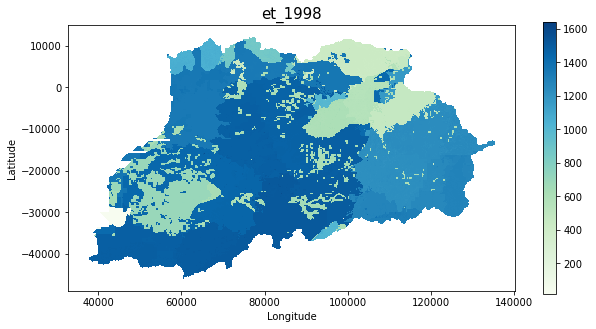

In [12]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

# Plot data
# Reference: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
wb_data_gpd[16].plot(column =wb_data_gpd[16].columns[1],ax = ax,cmap = "GnBu",legend = True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title(wb_data_gpd[16].columns[1], fontdict = {'fontsize': '15', 'fontweight' : '3'})

In [ ]:
#if needed to change projection to epsg 4326: modify this piece of code to reproject the files
data = geopandas.read_file(path+file_in)
# change CRS to epsg 4326
data = data.to_crs(epsg=4326)
# write shp file
data.to_file(path+file_out)

#refer to https://www.youtube.com/watch?v=KII8J0SSrUs&ab_channel=OpenSourceOptions

In [50]:
#shapefile bounds min_x, min_y, max_x, max_y
wb_data_gpd[0].total_bounds #shapefile bounds

min_x=wb_data_gpd[0].total_bounds[0]
min_y=wb_data_gpd[0].total_bounds[1]
max_x=wb_data_gpd[0].total_bounds[2]
max_y=wb_data_gpd[0].total_bounds[3]

12152.714592461838

### Export shapefiles to raster layers

The shapefiles are exported in their default projection carried over from SWAT+

In [13]:
#create a raster folder
raster_path=create_path('wb_rasters')
#####################################################################
shp_path=shp_path #path to shapefiles
shp_output=[]
shp_list = [file for file in os.listdir(shp_path) if file[-4:]=='.shp']

print('Exporting raster files...')
for i in range(0, len(shp_list)):
    shp=ogr.Open(shp_path + '/' + shp_list[i]) #loop through all shapefiles and read
    shp_output.append(shp) #append the shapefiles in a list

    input_layer=shp.GetLayer() #getting layer information of shapefile  
    input_srs = input_layer.GetSpatialRef()

    outraster_path=raster_path +'\\'+shp_list[i][:-4]+'_01_01.tif'

    pixel_size = 30
    x_min, x_max, y_min, y_max = input_layer.GetExtent()

    #calculate size / resolution of the raster.
    x_res = int(round((x_max - x_min) / pixel_size))
    y_res = int(round((y_max - y_min) / pixel_size))
    
    #passing the filename, x and y direction resolution, no.of bands, new raster.
    target_ds = gdal.GetDriverByName('GTiff').Create(outraster_path, x_res, y_res, 1, gdal.GDT_Float32,['COMPRESS=LZW'])

    #transforms between pixel raster space to projection coordinate space.
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))

    #target_dsSRS.ImportFromProj4(crs)
    target_dsSRS = osr.SpatialReference()
    proj='EPSG:32637'
    target_dsSRS.SetWellKnownGeogCS(proj)
    target_ds.SetProjection(target_dsSRS.ExportToWkt())
    
    #get required raster band.
    band=target_ds.GetRasterBand(1)
    no_data_value = -9999
    band.SetNoDataValue(no_data_value)
    band.Fill(-9999)
    band.FlushCache()

    #conversion
    gdal.RasterizeLayer(target_ds, [1], input_layer, None, None, [1], options=['ATTRIBUTE=et'])
    target_ds=None
    
print(simple_colors.green('All shapefiles successfully rasterized!', 'bold'))

Your outputs will be written to: E:\codes_jupyter\paper_publication\wb_rasters
Exporting raster files...
All shapefiles successfully rasterized!


### Raster files to netCDF

Notes:
Change the raster names to match the names in the raster folder
Change the time units accordingly
variable_names[0] refers to the index of 'et' in the variable_names list (refer to the summary_stats function above)

Change the min and max of lat and lon values


In [14]:
#define path to rasters
nc_path=create_path('wb_netCDF')

ds = gdal.Open(raster_path+'\wb_et_1982_01_01.tif') # Data location
a = ds.ReadAsArray()
nlat,nlon = np.shape(a)

b = ds.GetGeoTransform() #bbox, interval
lon = np.arange(nlon)*b[1]+b[0]
lat = np.arange(nlat)*b[5]+b[3]

basedate = dt.datetime(1981,1,1,0,0,0) #change base date according to period of


# Create NetCDF file
nco = netCDF4.Dataset(nc_path +'\\'+ 'simulated_'+list(var_dict)[0]+'.nc','w',clobber=True) # Output name


# Chunking is optional, but can improve access a lot: 
# (see: http://www.unidata.ucar.edu/blogs/developer/entry/chunking_data_choosing_shapes)
chunk_lon=10
chunk_lat=10
chunk_time=12

# Create dimensions, variables and attributes:
nco.createDimension('lon',nlon)
nco.createDimension('lat',nlat)
nco.createDimension('time',None)

timeo = nco.createVariable('time','f4',('time'))
timeo.units = ' years since 1982-1-1 00:00:00' #change the start time according to the data
timeo.standard_name = 'time'
timeo.calendar = 'gregorian'
timeo.axis = 'T'

lono = nco.createVariable('lon','f4',('lon'))
lono.units = 'metres'
lono.standard_name = 'longitude'
lono.long_name = 'longitude'
lono.axis = 'X'

lato = nco.createVariable('lat','f4',('lat'))
lato.units = 'metres'
lato.standard_name = 'latitude'
lato.long_name = 'latitude'
lato.axis = 'Y'

# Create container variable for CRS: lon/lat WGS84 datum
crso = nco.createVariable('crs','i4')
crso.long_name = 'Lon/Lat Coords in WGS84'
crso.grid_mapping_name='latitude_longitude'
crso.longitude_of_prime_meridian = 0.0
crso.semi_major_axis = 6378137.0
crso.inverse_flattening = 298.257223563

# Create float variable for landuse data, with chunking
pcpo = nco.createVariable('simulated ET', 'f4',  ('time', 'lat', 'lon'),zlib=True,chunksizes=[chunk_time,chunk_lat,chunk_lon],fill_value=-9999.)
pcpo.units = 'mm'
pcpo.standard_name = 'SWAT+ ET'
pcpo.long_name = 'Simulated actual evapotranspiration and interception'
pcpo.time_step = 'year'
pcpo.missing_value = -9999.
pcpo.geospatial_lat_min =min_y #from shapefile properties
pcpo.geospatial_lat_max =max_y
pcpo.geospatial_lon_min =min_x
pcpo.geospatial_lon_max =max_x
pcpo.grid_mapping = 'crs'
pcpo.set_auto_maskandscale(False)

# Additional attributes
nco.Conventions='CF-1.6'
nco.title = "swatplus simulated evapotranspiration"
nco.history = "created from hru annual water balance output of a calibrated SWAT+ model"
nco.version = "Version 2.0"
nco.comments = "time variable denotes the year."
nco.date_created = "2022-11-23"
nco.creator_name = "credits to Ethan Hunt"
nco.institution = "VUB"

# Write lon,lat
lono[:]=lon
lato[:]=lat

pat = re.compile('wb_et_[0-9]{4}\_[0-9]{2}\_[0-9]{2}') #reads the filename 
itime=0

# Step through data, writing time and data to NetCDF
for root, dirs, files in os.walk(raster_path):
        
        dirs.sort()
        files.sort()
        for f in files:
            if re.match(pat,f): #find a match for the filename (pat)
                # read the time values by parsing the filename
                year=int(f[-14:-10])
                mon=int(f[-9:-7])
                day=int(f[-6:-4])
                date=dt.datetime(year,mon,day,0,0)
                #print(date)
                dtime=relativedelta(date,basedate).years
                #dtime=(date-basedate).total_seconds()
                timeo[itime]=dtime
               
                #data
                pcp_path = os.path.join(root,f)
                print(pcp_path)
                pcp=gdal.Open(pcp_path)
                a=pcp.ReadAsArray()  #data
                pcpo[itime,:,:]=a
                itime=itime+1
print('\n')
print(simple_colors.green('All raster files successfully written to nc file!', 'bold'))
nco.close()


Your outputs will be written to: E:\codes_jupyter\paper_publication\wb_netCDF
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1982_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1983_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1984_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1985_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1986_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1987_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1988_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1989_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1990_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1991_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1992_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1993_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et_1994_01_01.tif
E:\codes_jupyter\paper_publication\wb_rasters\wb_et

In [15]:
swat_et = xr.open_dataset(nc_path+'\simulated_et_v2.nc', decode_times=False)
units, reference_date = swat_et.time.attrs['units'].split('since')
swat_et['time'] = pd.date_range(start=reference_date, periods=swat_et.sizes['time'], freq='y')
swat_et['time']

<xarray.DataArray 'time' (time: 24)>
array(['1982-12-31T00:00:00.000000000', '1983-12-31T00:00:00.000000000',
       '1984-12-31T00:00:00.000000000', '1985-12-31T00:00:00.000000000',
       '1986-12-31T00:00:00.000000000', '1987-12-31T00:00:00.000000000',
       '1988-12-31T00:00:00.000000000', '1989-12-31T00:00:00.000000000',
       '1990-12-31T00:00:00.000000000', '1991-12-31T00:00:00.000000000',
       '1992-12-31T00:00:00.000000000', '1993-12-31T00:00:00.000000000',
       '1994-12-31T00:00:00.000000000', '1995-12-31T00:00:00.000000000',
       '1996-12-31T00:00:00.000000000', '1997-12-31T00:00:00.000000000',
       '1998-12-31T00:00:00.000000000', '1999-12-31T00:00:00.000000000',
       '2000-12-31T00:00:00.000000000', '2001-12-31T00:00:00.000000000',
       '2002-12-31T00:00:00.000000000', '2003-12-31T00:00:00.000000000',
       '2004-12-31T00:00:00.000000000', '2005-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-12-31 1983-12-31 ... 2005-12-31

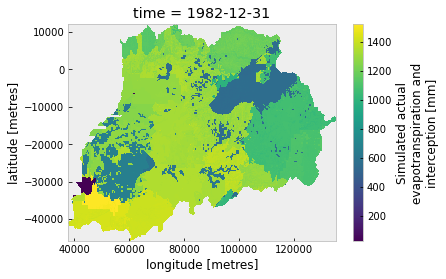

In [16]:
swat_et['simulated ET'][0].plot()

### Visualizing netCDF data

In [17]:
#extents of region of interest
min_lon=swat_et['lon'].min()+1500
max_lon=swat_et['lon'].max()+1500
min_lat=swat_et['lat'].min()+1500
max_lat= swat_et['lon'].max()+1500

#range of values
vmin=swat_et['simulated ET'].min()
vmax=swat_et['simulated ET'].max()

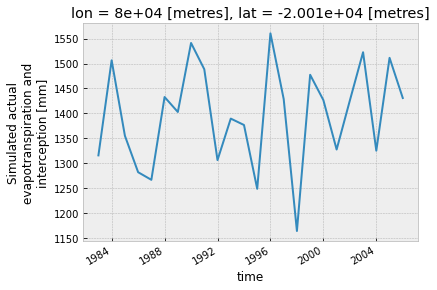

In [18]:
swat_et=swat_et['simulated ET'].sel(lat=-20000, lon=80000, method='nearest')
swat_et.plot()

### References

References:
https://www.youtube.com/watch?v=lQW9zK79M80&ab_channel=GeoGISLabs

https://www.programcreek.com/python/example/101827/gdal.RasterizeLayer

Ref: https://stackoverflow.com/questions/66705955/creating-subplots-through-a-loop-from-a-dataframe